<a href="https://colab.research.google.com/github/santiagogiasone/COVID-PersonLimiter/blob/master/Cuaderno_1_grupo17_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Introducción**




El siguiente ejemplo modifica el color de una imágen parametrizada, a escala de grises. El cálculo de la escala se realiza convirtiendo los 3 canales RGB, que representan a los colores R (rojo)-G(verde)-B(azul) de cada pixel, generando el complemento del valor de cada componente:
<center><br>$ Pixel= (255-R, 255-G, 255-B)$</center></br>

EL objetivo es enseñar el funcionamiento del Lenguaje Python, CUDA y el manejo de imagenes a bajo nivel.


---



### **Armado del ambiente**
Toma la direcciòn web de una imagen con acceso público en internet, la deja disponible al contexto de ejecuciòn del cuaderno colab.

Obtencion de imagen

In [1]:
### Parámetros de ejecución

#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://columnacero.com/pic/25689/spider-man-un-nuevo-universo.jpg" #@param {type:"string"}
#link a imagen de prueba https://columnacero.com/pic/25689/spider-man-un-nuevo-universo.jpg
# Leo la imagen desde internet y la almaceno "localmente" como imagen.jpg
!wget {url_imagen} -O imagen.jpg

--2021-11-24 04:07:54--  https://columnacero.com/pic/25689/spider-man-un-nuevo-universo.jpg
Resolving columnacero.com (columnacero.com)... 82.223.205.134
Connecting to columnacero.com (columnacero.com)|82.223.205.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190423 (186K) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>] 185.96K   367KB/s    in 0.5s    

2021-11-24 04:07:56 (367 KB/s) - ‘imagen.jpg’ saved [190423/190423]



 Tener en cuenta que tambien es necesario instalar la libreria de la GPU como asi tambien verificar que este activo el entorno de ejecucion de GPU

In [2]:
!pip install pycuda



---



### **Desarrollo CPU**

Imagen del filtro: imagen.jpg -RGB- [1280, 720]
Tiempo de conversión de imagen: 10273.223 [ms]
Tiempo Total: 10350.427 [ms]


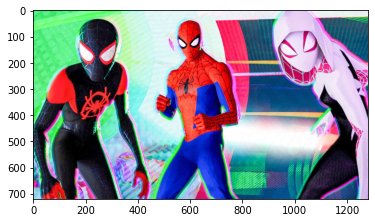

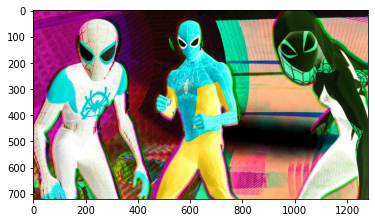

In [ ]:
 %matplotlib inline
from datetime import datetime

tiempo_total = datetime.now()

import  matplotlib.pyplot as plt
import numpy
from PIL import Image 

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------


img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# Obtengo las proporsiones de la imagen. 
img_ancho, img_alto = image.size 

#Convierto la imagen a array.
img_pic_cpu = numpy.asarray(image)
img_pic_cpu = img_pic_cpu.astype(numpy.int32())

# Genero el array resultado mismo tamaño que el de la imagen original
img_picR_cpu = numpy.empty_like(img_pic_cpu)

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto) + "]" )  

plt.figure()
imgplot=plt.imshow(img_pic_cpu)

tiempo_img = datetime.now()

# Se realiza la inversion de color
for y  in range( 0, img_alto ): #(int)(img_alto/2)
  for x in range( 0, img_ancho ):
    pixel_R, pixel_G, pixel_B = img_pic_cpu[y][x]
    img_picR_cpu[y][x] = [255-pixel_R, 255-pixel_G, 255-pixel_B]

tiempo_img = datetime.now() - tiempo_img

# Muestro la imagen luego de la inversion del color.
plt.figure()
imgplot = plt.imshow( img_picR_cpu )

tiempo_total = datetime.now() - tiempo_total

print( "Tiempo de conversión de imagen:", tiempo_en_ms( tiempo_img   ), "[ms]" )
print( "Tiempo Total:",                   tiempo_en_ms( tiempo_total ), "[ms]" )



---




### **Desarrollo GPU**




Imagen del filtro: imagen.jpg -RGB- [1280, 720]
Thread: [ 16 , 10  ], Bloque : [ 80 , 72 ]
Total de Thread: [ 1280 , 720  ]  =  921600
Tiempo GPU  :  0.259 [ms]
Tiempo TOTAL:  113.603 [ms]


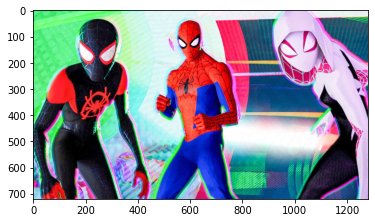

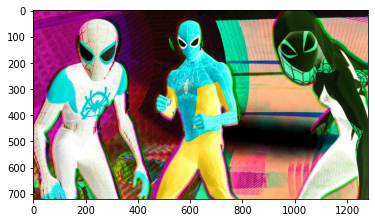

In [9]:
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# Obtengo las proporciones de la imagen. 
img_ancho, img_alto  = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_O_cpu = img_O_cpu.astype( numpy.int32() )
img_R_cpu = numpy.empty_like( img_O_cpu)

# Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
#+ (int)(alto/2) en int idy
module = SourceModule("""
__global__ void kernel_img( int ancho, int alto, int *img_O, int *img_R )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  int red=0;
  int green=0;
  int blue=0;

  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto )
  {
    //calculo el valor de cada pixel
    red=255-(img_O[(idx+(idy*ancho))*3  ]);// Componente Rojo del pixel.
    green=255-(img_O[((idx+(idy*ancho))*3)+1]);// Componente Verde del pixel.
    blue=255-(img_O[((idx+(idy*ancho))*3)+2]);// Componente Azul del pixel.

    //escribo el color de cada pixel.
    img_R[(idx+(idy*ancho))*3  ] = red;
    img_R[((idx+(idy*ancho))*3)+1] = green;
    img_R[((idx+(idy*ancho))*3)+2] = blue;
  }
}
""") 

# Muestro los atributos de la imagen y como se ve antes del filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_img")

tiempo_img = datetime.now()

dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 10
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img = datetime.now()

kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=(dim_hilo_x,dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) ) 

tiempo_img = datetime.now() - tiempo_img

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

tiempo_total = datetime.now() - tiempo_total

print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" )
print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )

### **Metricas**


```
# CPU=
Imagen del filtro: imagen.jpg -RGB- [1280, 720]
Tiempo de conversión de imagen: 9493.05 [ms]
Tiempo Total: 9614.785 [ms]
```
        

```
# GPU=
Thread: [ 16 , 10  ], Bloque : [ 80 , 72 ]
Total de Thread: [ 1296 , 730  ]  =  946080
Tiempo GPU  :  0.164 [ms]
Tiempo TOTAL:  91.66 [ms]
```



### Conclusiones
El tiempo de procesamiento de la imagen en GPU es considerablemente menor, para este tipo de proyectos donde se realiza el mismo calculo repetidamente para una gran cantidad de datos es muy recomendable resolverlo con GPU ya que es una tarea paralelizable.

### Bibliografia
[Ejercicio GPU "Escala de grises" provisto por la catedra](https://github.com/wvaliente/SOA_HPC/blob/main/Ejercicios/Prueba%202%20-%20Imagen%20-%20GPU.ipynb)                   
[Ejercicio CPU "Escala de grises" provisto por la catedra](https://github.com/wvaliente/SOA_HPC/blob/main/Ejercicios/Prueba%202%20-%20Imagen%20-%20CPU.ipynb)         
[Algoritmo de inversion de color](https://programmerclick.com/article/1612326767/)

In [7]:
!nvidia-smi

Wed Nov 24 03:00:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    63W / 149W |    143MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-0a4ab7e3-08fd-8248-da56-8f16cbdb4208)


In [3]:
!cd  /usr/local/cuda/samples/1_Utilities/deviceQuery/; make >/dev/null
!/usr/local/cuda/samples/1_Utilities/deviceQuery/deviceQuery | grep "Max dimension"

nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
  Max dimension size of a thread block (x,y,z): (1024, 1024, 64)
  Max dimension size of a grid size    (x,y,z): (2147483647, 65535, 65535)
